In [1]:
import tensorflow as tf
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from tqdm import tqdm

## Optical digits

In [2]:
train_file = './uci_repos/optical_digits/optdigits.tra'
test_file = './uci_repos/optical_digits/optdigits.tes'
column = ['pixel_'+str(i) for i in range(64)]
column.append('digit_label')
train_data = pd.read_csv(train_file, sep=',', header=None, names=column)
test_data = pd.read_csv(test_file, sep=',', header=None, names=column)

In [3]:
test_data.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_55,pixel_56,pixel_57,pixel_58,pixel_59,pixel_60,pixel_61,pixel_62,pixel_63,digit_label
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4


In [4]:
def group_all_labels(data, num=100, minor=[]):
    # this function is to limit the number of labels that are used
    # it returns the indexes according the labels
    # data is an array of labels
    '''

    :param data: array of labels
    :param num: number required
    :param minor: list of minority indexes
    :return: array of labels indexes
    '''

    labels = np.unique(data)
    co_l = []
    min_col =[]
    if not minor:
        for l in labels:
            el_l = np.where(np.array(data) == l)
            co_l.append(el_l[0])

    else:
        for l in labels:
            if l in minor:
                el_l = np.where(np.array(data) == l)
                co_l.append((el_l[0])[:num])
                min_col.append((el_l[0])[:num])
            else:
                el_l = np.where(np.array(data) == l)
                co_l.append(el_l[0])
    return co_l, min_col

In [5]:
train_y = train_data.iloc[:,-1:].copy().to_numpy()
train_images = train_data.iloc[:, 0:-1].copy().to_numpy()
y_test = test_data.iloc[:,-1:].copy().to_numpy()
test_images = test_data.iloc[:, 0:-1].copy().to_numpy()

In [6]:
grouped_labels, min_label = group_all_labels(train_y, 100, [0, 1])
gr_data = []
gr_labels = [] 
for index, q in enumerate(grouped_labels):
    print('class {} : number of samples : {}'.format(index,len(q)))
    for r in q:
        gr_data.append(train_images[r])
        gr_labels.append(train_y[r])

class 0 : number of samples : 100
class 1 : number of samples : 100
class 2 : number of samples : 380
class 3 : number of samples : 389
class 4 : number of samples : 387
class 5 : number of samples : 376
class 6 : number of samples : 377
class 7 : number of samples : 387
class 8 : number of samples : 380
class 9 : number of samples : 382


In [7]:
np.unique(y_test)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

train image size :  (3258, 64)
train y size :  (3258, 10)
test image size :  (1797, 64)
test y size :  (1797, 10)
sample y : [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


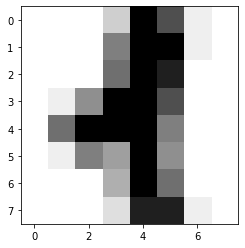

In [8]:
#train_images = [np.reshape(x, (8,8, 1)) for x in train_images ]
train_images = np.array(gr_data).astype(np.float32) / 16.0
#test_images = [np.reshape(x, (8,8, 1)) for x in test_images ]
test_images = np.array(test_images).astype(np.float32) / 16.0

train_y = tf.keras.utils.to_categorical(gr_labels, num_classes=10, dtype='float32')
test_y = tf.keras.utils.to_categorical(y_test, num_classes=10, dtype='float32')
print('train image size : ', train_images.shape)
print('train y size : ', train_y.shape)
print('test image size : ', test_images.shape)
print('test y size : ', test_y.shape)
print('sample y :', train_y[0])
plt.imshow(np.reshape(train_images[100],(8,8)), cmap=plt.cm.gray_r, interpolation='nearest')

### VAE

In [9]:
import tensorflow.compat.v1  as tf
tf.disable_v2_behavior()
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import os
import numpy as np

mb_size = 64
z_dim = 10
X_dim = 64
y_dim = 10
h_dim = 16
lr = 1e-3


def plot(samples):
    fig = plt.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(8, 8)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(8, 8), cmap='Greys_r')

    return fig


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random.normal(shape=size, stddev=xavier_stddev)


# Q(z|X) 

X = tf.keras.Input(shape=(X_dim,))
c = tf.keras.Input(shape=(y_dim,))
z = tf.keras.Input(shape=(z_dim,))

Q_W1 = tf.Variable(xavier_init([X_dim + y_dim, h_dim]))
Q_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

Q_W2_mu = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_mu = tf.Variable(tf.zeros(shape=[z_dim]))

Q_W2_sigma = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_sigma = tf.Variable(tf.zeros(shape=[z_dim]))


def Q(X, c):
    inputs = tf.concat(axis=1, values=[X, c])
    h = tf.nn.relu(tf.matmul(inputs, Q_W1) + Q_b1)
    z_mu = tf.matmul(h, Q_W2_mu) + Q_b2_mu
    z_logvar = tf.matmul(h, Q_W2_sigma) + Q_b2_sigma
    return z_mu, z_logvar


def sample_z(mu, log_var):
    eps = tf.random.normal(shape=tf.shape(mu))
    return mu + tf.exp(log_var / 2) * eps


# P(X|z)

P_W1 = tf.Variable(xavier_init([z_dim + y_dim, h_dim]))
P_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

P_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
P_b2 = tf.Variable(tf.zeros(shape=[X_dim]))


def P(z, c):
    inputs = tf.concat(axis=1, values=[z, c])
    h = tf.nn.relu(tf.matmul(inputs, P_W1) + P_b1)
    logits = tf.matmul(h, P_W2) + P_b2
    prob = tf.nn.sigmoid(logits)
    return prob, logits

z_mu, z_logvar = Q(X, c)
z_sample = sample_z(z_mu, z_logvar)
_, logits = P(z_sample, c)

# Sampling from random z
X_samples, _ = P(z, c)

# E[log P(X|z)]
recon_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=X), 1)
kl_loss = 0.5 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)

# VAE loss
vae_loss = tf.reduce_mean(recon_loss + kl_loss)

# gradient step
solver = tf.compat.v1.train.AdamOptimizer().minimize(vae_loss)
sess = tf.compat.v1.Session ()
sess.run(
tf.compat.v1.global_variables_initializer())

# if not os.path.exists('samples_opt_100/'):
#     os.makedirs('samples_opt_100/')

i = 0

for it in range(100000):
    ind = np.random.choice(train_images.shape[0], mb_size)
    X_mb = np.array(train_images[ind])
    y_mb = np.array(train_y[ind])
    
    _, loss = sess.run([solver, vae_loss], feed_dict={X: X_mb, c: y_mb})

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {:.2}'. format(loss))

#         y = np.zeros(shape=[64, y_dim])
#         y[:, np.random.randint(0, y_dim)] = 1.

#         samples = sess.run(X_samples,
#                            feed_dict={z: np.random.randn(64, z_dim), c: y})

#         fig = plot(samples)
#         plt.savefig('samples_opt_100/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
#         i += 1
#         plt.close(fig)



Instructions for updating:
non-resource variables are not supported in the long term


2021-11-08 09:44:42.406527: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-08 09:44:42.415557: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2021-11-08 09:44:42.416692: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-11-08 09:44:42.418008: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library

Iter: 0
Loss: 5.3e+01
Iter: 1000
Loss: 2.4e+01
Iter: 2000
Loss: 2.2e+01
Iter: 3000
Loss: 2.2e+01
Iter: 4000
Loss: 2.2e+01
Iter: 5000
Loss: 2.2e+01
Iter: 6000
Loss: 2.2e+01
Iter: 7000
Loss: 2.2e+01
Iter: 8000
Loss: 2.3e+01
Iter: 9000
Loss: 2.1e+01
Iter: 10000
Loss: 2.2e+01
Iter: 11000
Loss: 2.1e+01
Iter: 12000
Loss: 2.2e+01
Iter: 13000
Loss: 2.1e+01
Iter: 14000
Loss: 2.1e+01
Iter: 15000
Loss: 2.1e+01
Iter: 16000
Loss: 2.1e+01
Iter: 17000
Loss: 2.1e+01
Iter: 18000
Loss: 2.1e+01
Iter: 19000
Loss: 2.2e+01
Iter: 20000
Loss: 2.1e+01
Iter: 21000
Loss: 2.2e+01
Iter: 22000
Loss: 2.2e+01
Iter: 23000
Loss: 2.1e+01
Iter: 24000
Loss: 2.2e+01
Iter: 25000
Loss: 2.2e+01
Iter: 26000
Loss: 2.1e+01
Iter: 27000
Loss: 2.2e+01
Iter: 28000
Loss: 2.2e+01
Iter: 29000
Loss: 2.1e+01
Iter: 30000
Loss: 2.1e+01
Iter: 31000
Loss: 2.2e+01
Iter: 32000
Loss: 2.1e+01
Iter: 33000
Loss: 2.2e+01
Iter: 34000
Loss: 2.2e+01
Iter: 35000
Loss: 2.3e+01
Iter: 36000
Loss: 2.2e+01
Iter: 37000
Loss: 2.2e+01
Iter: 38000
Loss: 2.2e+01

In [10]:
### generating sample outputs after training
def generate_samples():
    samples = []
    gen_labels =[]
    for r in range(10):
        for index in range(2):
            gen_labels = gen_labels + [index]*64
            y = np.zeros([mb_size, y_dim])
            y[range(mb_size), index] = 1
            samples.extend(sess.run(X_samples,
                                   feed_dict={z: np.random.randn(64, z_dim), c: y}))

    gen_samples = np.array(samples)
    gen_labels = np.array(gen_labels)
    
    return gen_samples, gen_labels

# Visualize generated samples

In [11]:
aug_samples, aug_labels = generate_samples()
aug_samples.shape, aug_labels.shape 

((1280, 64), (1280,))

1


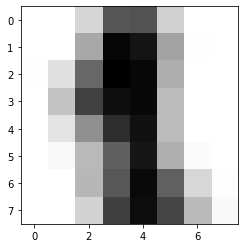

In [12]:
print(aug_labels[70])
plt.imshow(np.reshape(aug_samples[70],(8,8)), cmap=plt.cm.gray_r, interpolation='nearest')

In [13]:
# normiziling pixel between 0..16 similar to the original data.
#norm_xtrain = (16*(gen_samples - np.min(gen_samples))/np.ptp(gen_samples)).astype(int) 

# MLP Model

In [14]:
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input, Flatten
from tensorflow.keras.models import Sequential


def build_model(input_shape=(64,), num_classes=10):
    """

    :param input_shape: shape of input_data
    :param num_classes: number of classes
    :return: keras.model.sequential compiled with categorical cross-entropy loss
    """
    model = Sequential([
        Input(shape=input_shape),
        Dense(32, activation="relu"),
        BatchNormalization(),
        Dense(64, activation="relu"),
        BatchNormalization(),
        Flatten(),
        Dropout(0.5),
        Dense(num_classes, activation="softmax"),
    ])

    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.summary()
    return model

# Baseline Experiment

In [15]:
def post_process_results(b_list, filename='default.csv'):
    total_df = pd.DataFrame(b_list[0]).transpose()
    print('number of runs: {}'.format(len(b_list)))
    for r_dict in b_list[1:]:
        temp = pd.DataFrame(r_dict).transpose()
        total_df = total_df.add(temp)
        
    average_pd = total_df/10.0
    average_pd.to_csv(filename, sep=',')
    
    return average_pd

In [16]:
baseline_list =[]
for i in range(10):
    model = build_model()
    batch_size=8
    epochs=2
    history = model.fit(train_images, train_y, batch_size=batch_size, epochs=epochs, 
                        validation_data=(test_images, test_y))
    score = model.evaluate(test_images, test_y, verbose=0)
    print('test loss: ',score[0])
    print('test accuracy: ', score[1] )
    y_pred_oh = model.predict(test_images)
    y_pred_baseline = y_pred_oh.argmax(axis=-1)
    from sklearn.metrics import classification_report
    baseline_list.append(classification_report(y_test, y_pred_baseline, output_dict=True))

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
__________________________________________________

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


3258/3258 [==============================] - 1s 204us/sample - loss: 0.7028 - acc: 0.7772 - val_loss: 0.3740 - val_acc: 0.8837
test loss:  0.3740360666611623
test accuracy:  0.88369507
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2112      
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)                256       
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
d

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


3258/3258 [==============================] - 1s 210us/sample - loss: 0.7659 - acc: 0.7621 - val_loss: 0.4538 - val_acc: 0.8664
test loss:  0.45377484361994047
test accuracy:  0.86644405
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
batch_normalization_4 (Batch (None, 32)                128       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                2112      
_________________________________________________________________
batch_normalization_5 (Batch (None, 64)                256       
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)                0         
_________________________________________________________________


/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


3258/3258 [==============================] - 1s 269us/sample - loss: 1.4713 - acc: 0.5378 - val_loss: 0.5519 - val_acc: 0.8442
Epoch 2/2
3258/3258 [==============================] - 1s 210us/sample - loss: 0.6774 - acc: 0.7845 - val_loss: 0.2961 - val_acc: 0.9182
test loss:  0.29609036029347063
test accuracy:  0.918197
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
batch_normalization_6 (Batch (None, 32)                128       
_________________________________________________________________
dense_10 (Dense)             (None, 64)                2112      
_________________________________________________________________
batch_normalization_7 (Batch (None, 64)                256       
_______________________________________________________________

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


3258/3258 [==============================] - 1s 280us/sample - loss: 1.4230 - acc: 0.5562 - val_loss: 0.5685 - val_acc: 0.8347
Epoch 2/2
3258/3258 [==============================] - 1s 212us/sample - loss: 0.6770 - acc: 0.7897 - val_loss: 0.3445 - val_acc: 0.8959
test loss:  0.3445104142701752
test accuracy:  0.8959377
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_8 (Batch (None, 32)                128       
_________________________________________________________________
dense_13 (Dense)             (None, 64)                2112      
_________________________________________________________________
batch_normalization_9 (Batch (None, 64)                256       
_______________________________________________________________

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


3258/3258 [==============================] - 1s 293us/sample - loss: 1.3728 - acc: 0.5638 - val_loss: 0.5787 - val_acc: 0.8225
Epoch 2/2
3258/3258 [==============================] - 1s 219us/sample - loss: 0.6589 - acc: 0.7977 - val_loss: 0.3943 - val_acc: 0.8776
test loss:  0.3942760984870954
test accuracy:  0.8775737
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_10 (Batc (None, 32)                128       
_________________________________________________________________
dense_16 (Dense)             (None, 64)                2112      
_________________________________________________________________
batch_normalization_11 (Batc (None, 64)                256       
_______________________________________________________________

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


3258/3258 [==============================] - 1s 312us/sample - loss: 1.4953 - acc: 0.5310 - val_loss: 0.5546 - val_acc: 0.8280
Epoch 2/2
3258/3258 [==============================] - 1s 225us/sample - loss: 0.6910 - acc: 0.7784 - val_loss: 0.3478 - val_acc: 0.8787
test loss:  0.34775268860704445
test accuracy:  0.8786867
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_12 (Batc (None, 32)                128       
_________________________________________________________________
dense_19 (Dense)             (None, 64)                2112      
_________________________________________________________________
batch_normalization_13 (Batc (None, 64)                256       
______________________________________________________________

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


3258/3258 [==============================] - 1s 330us/sample - loss: 1.5267 - acc: 0.5310 - val_loss: 0.5630 - val_acc: 0.8408
Epoch 2/2
3258/3258 [==============================] - 1s 228us/sample - loss: 0.6964 - acc: 0.7784 - val_loss: 0.3136 - val_acc: 0.8943
test loss:  0.3136024434569317
test accuracy:  0.8942682
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_14 (Batc (None, 32)                128       
_________________________________________________________________
dense_22 (Dense)             (None, 64)                2112      
_________________________________________________________________
batch_normalization_15 (Batc (None, 64)                256       
_______________________________________________________________

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


3258/3258 [==============================] - 1s 341us/sample - loss: 1.4645 - acc: 0.5390 - val_loss: 0.6222 - val_acc: 0.8230
Epoch 2/2
3258/3258 [==============================] - 1s 241us/sample - loss: 0.7157 - acc: 0.7787 - val_loss: 0.3458 - val_acc: 0.8943
test loss:  0.3458232584849423
test accuracy:  0.8942682
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_16 (Batc (None, 32)                128       
_________________________________________________________________
dense_25 (Dense)             (None, 64)                2112      
_________________________________________________________________
batch_normalization_17 (Batc (None, 64)                256       
_______________________________________________________________

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


3258/3258 [==============================] - 1s 353us/sample - loss: 1.4495 - acc: 0.5528 - val_loss: 0.5696 - val_acc: 0.8253
Epoch 2/2
3258/3258 [==============================] - 1s 242us/sample - loss: 0.7119 - acc: 0.7802 - val_loss: 0.4066 - val_acc: 0.8776
test loss:  0.40660757647747453
test accuracy:  0.8775737
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_18 (Batc (None, 32)                128       
_________________________________________________________________
dense_28 (Dense)             (None, 64)                2112      
_________________________________________________________________
batch_normalization_19 (Batc (None, 64)                256       
______________________________________________________________

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


3258/3258 [==============================] - 1s 366us/sample - loss: 1.5706 - acc: 0.5141 - val_loss: 0.7502 - val_acc: 0.7947
Epoch 2/2
3258/3258 [==============================] - 1s 246us/sample - loss: 0.7459 - acc: 0.7670 - val_loss: 0.4900 - val_acc: 0.8525
test loss:  0.4900228850580814
test accuracy:  0.85253197


In [17]:
post_process_results(baseline_list, 'results_csv/opt_baseline_cnn.csv')

number of runs: 10


,precision,recall,f1-score,support
0,0.981067,0.931461,0.954938,178.000000
1,0.913326,0.506044,0.641678,182.000000
2,0.909180,0.942938,0.924867,177.000000
3,0.907387,0.908743,0.907034,183.000000
4,0.904440,0.970718,0.935437,181.000000
5,0.901739,0.968681,0.933619,182.000000
6,0.927349,0.966298,0.945800,181.000000
7,0.942483,0.888268,0.913820,179.000000
8,0.707861,0.868966,0.777202,174.000000
9,0.827902,0.890000,0.855142,180.000000


# Augmentation Experiment

In [18]:
results_list = []
for i in range(10):
    gen_samples, gen_labels = generate_samples()
    gen_y = tf.keras.utils.to_categorical(gen_labels, num_classes=10, dtype='float32')
    X = np.concatenate([train_images, gen_samples])
    Y = np.concatenate([train_y, gen_y])
    model_aug = build_model()
    history_aug = model_aug.fit(X, Y, batch_size=batch_size, epochs=epochs, validation_data=(test_images, test_y))
    
    aug_score = model_aug.evaluate(test_images, test_y, verbose=0)
    print('test loss for {}th run: '.format(i), aug_score[0])
    print('test accuracy for {}th run: '.format(i), aug_score[1] )
    
    y_pred_aug_oh = model_aug.predict(test_images)
    y_pred_aug = y_pred_aug_oh.argmax(axis=-1)
    results_list.append(classification_report(y_test, y_pred_aug, output_dict=True))

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_20 (Batc (None, 32)                128       
_________________________________________________________________
dense_31 (Dense)             (None, 64)                2112      
_________________________________________________________________
batch_normalization_21 (Batc (None, 64)                256       
_________________________________________________________________
flatten_10 (Flatten)         (None, 64)                0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 10)              

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


4538/4538 [==============================] - 2s 337us/sample - loss: 1.0117 - acc: 0.6904 - val_loss: 0.3468 - val_acc: 0.8943
Epoch 2/2
4538/4538 [==============================] - 1s 245us/sample - loss: 0.4318 - acc: 0.8658 - val_loss: 0.3057 - val_acc: 0.9104
test loss for 0th run:  0.30570339290534015
test accuracy for 0th run:  0.91040623
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_22 (Batc (None, 32)                128       
_________________________________________________________________
dense_34 (Dense)             (None, 64)                2112      
_________________________________________________________________
batch_normalization_23 (Batc (None, 64)                256       
____________________________________

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


4538/4538 [==============================] - 2s 342us/sample - loss: 1.1799 - acc: 0.6254 - val_loss: 0.4131 - val_acc: 0.8759
Epoch 2/2
4538/4538 [==============================] - 1s 246us/sample - loss: 0.4980 - acc: 0.8438 - val_loss: 0.3409 - val_acc: 0.8915
test loss for 1th run:  0.340894561425747
test accuracy for 1th run:  0.8914858
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_24 (Batc (None, 32)                128       
_________________________________________________________________
dense_37 (Dense)             (None, 64)                2112      
_________________________________________________________________
batch_normalization_25 (Batc (None, 64)                256       
_______________________________________

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


4538/4538 [==============================] - 2s 353us/sample - loss: 1.1388 - acc: 0.6492 - val_loss: 0.3327 - val_acc: 0.8937
Epoch 2/2
4538/4538 [==============================] - 1s 250us/sample - loss: 0.4798 - acc: 0.8521 - val_loss: 0.2868 - val_acc: 0.9132
test loss for 2th run:  0.286790833828694
test accuracy for 2th run:  0.91318864
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_26 (Batc (None, 32)                128       
_________________________________________________________________
dense_40 (Dense)             (None, 64)                2112      
_________________________________________________________________
batch_normalization_27 (Batc (None, 64)                256       
______________________________________

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


4538/4538 [==============================] - 2s 363us/sample - loss: 1.1272 - acc: 0.6551 - val_loss: 0.3629 - val_acc: 0.8826
Epoch 2/2
4538/4538 [==============================] - 1s 256us/sample - loss: 0.4721 - acc: 0.8607 - val_loss: 0.2539 - val_acc: 0.9165
test loss for 3th run:  0.253944815818011
test accuracy for 3th run:  0.91652757
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_28 (Batc (None, 32)                128       
_________________________________________________________________
dense_43 (Dense)             (None, 64)                2112      
_________________________________________________________________
batch_normalization_29 (Batc (None, 64)                256       
______________________________________

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


4538/4538 [==============================] - 2s 370us/sample - loss: 1.1953 - acc: 0.6267 - val_loss: 0.4316 - val_acc: 0.8770
Epoch 2/2
4538/4538 [==============================] - 1s 260us/sample - loss: 0.4840 - acc: 0.8499 - val_loss: 0.3096 - val_acc: 0.9021
test loss for 4th run:  0.30955893476688007
test accuracy for 4th run:  0.90205896
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_30 (Batc (None, 32)                128       
_________________________________________________________________
dense_46 (Dense)             (None, 64)                2112      
_________________________________________________________________
batch_normalization_31 (Batc (None, 64)                256       
____________________________________

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


4538/4538 [==============================] - 2s 387us/sample - loss: 1.1457 - acc: 0.6554 - val_loss: 0.4073 - val_acc: 0.8792
Epoch 2/2
4538/4538 [==============================] - 1s 266us/sample - loss: 0.4538 - acc: 0.8587 - val_loss: 0.2895 - val_acc: 0.9093
test loss for 5th run:  0.28949252350704663
test accuracy for 5th run:  0.9092933
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_32 (Batc (None, 32)                128       
_________________________________________________________________
dense_49 (Dense)             (None, 64)                2112      
_________________________________________________________________
batch_normalization_33 (Batc (None, 64)                256       
_____________________________________

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


4538/4538 [==============================] - 2s 401us/sample - loss: 1.0757 - acc: 0.6736 - val_loss: 0.4313 - val_acc: 0.8737
Epoch 2/2
4538/4538 [==============================] - 1s 275us/sample - loss: 0.4396 - acc: 0.8709 - val_loss: 0.3100 - val_acc: 0.9004
test loss for 6th run:  0.3099774638508044
test accuracy for 6th run:  0.90038955
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_34 (Batc (None, 32)                128       
_________________________________________________________________
dense_52 (Dense)             (None, 64)                2112      
_________________________________________________________________
batch_normalization_35 (Batc (None, 64)                256       
_____________________________________

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


4538/4538 [==============================] - 2s 427us/sample - loss: 1.1157 - acc: 0.6523 - val_loss: 0.4113 - val_acc: 0.8625
Epoch 2/2
4538/4538 [==============================] - 2s 335us/sample - loss: 0.4845 - acc: 0.8519 - val_loss: 0.2975 - val_acc: 0.9054
test loss for 7th run:  0.2974753447258446
test accuracy for 7th run:  0.9053979
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_36 (Batc (None, 32)                128       
_________________________________________________________________
dense_55 (Dense)             (None, 64)                2112      
_________________________________________________________________
batch_normalization_37 (Batc (None, 64)                256       
______________________________________

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


4538/4538 [==============================] - 2s 525us/sample - loss: 1.1032 - acc: 0.6547 - val_loss: 0.3951 - val_acc: 0.8831
Epoch 2/2
4538/4538 [==============================] - 1s 296us/sample - loss: 0.4970 - acc: 0.8471 - val_loss: 0.2499 - val_acc: 0.9193
test loss for 8th run:  0.24990354760969238
test accuracy for 8th run:  0.91931
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_38 (Batc (None, 32)                128       
_________________________________________________________________
dense_58 (Dense)             (None, 64)                2112      
_________________________________________________________________
batch_normalization_39 (Batc (None, 64)                256       
_______________________________________

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


4538/4538 [==============================] - 2s 440us/sample - loss: 1.0970 - acc: 0.6644 - val_loss: 0.4161 - val_acc: 0.8715
Epoch 2/2
4538/4538 [==============================] - 1s 292us/sample - loss: 0.4699 - acc: 0.8550 - val_loss: 0.3184 - val_acc: 0.8965
test loss for 9th run:  0.3184420837563114
test accuracy for 9th run:  0.89649415


In [19]:
post_process_results(results_list, 'results_csv/opt_VAE.csv')

number of runs: 10


,precision,recall,f1-score,support
0,0.985277,0.964045,0.974441,178.000000
1,0.918026,0.729121,0.810623,182.000000
2,0.919842,0.952542,0.934878,177.000000
3,0.955297,0.899454,0.926116,183.000000
4,0.906845,0.967956,0.935996,181.000000
5,0.882991,0.969780,0.923931,182.000000
6,0.972228,0.967403,0.969522,181.000000
7,0.956447,0.889944,0.921265,179.000000
8,0.753923,0.844253,0.794786,174.000000
9,0.857290,0.880000,0.866328,180.000000


# Random UnderSmapling

In [20]:
undersampling_list =[]
for i in range(10):
    bl_model = build_model()
    batch_size=64
    epochs=30
    
    rus = RandomUnderSampler(random_state=42)
    X_train, y_train1 = rus.fit_resample(train_images, train_y)
    
    bl_history = bl_model.fit(X_train, y_train1, batch_size=batch_size,
                        epochs=epochs, validation_data=(test_images, test_y))

    bl_score = bl_model.evaluate(test_images, test_y, verbose=0)
    print('undersampling test loss: ', bl_score[0])
    print('undersampling accuracy: ', bl_score[1] )

    from sklearn.metrics import classification_report
    y_pred_oh = bl_model.predict(test_images)
    y_pred_aug = y_pred_oh.argmax(axis=-1)
    undersampling_list.append(classification_report(y_test, y_pred_aug, output_dict=True))

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_40 (Batc (None, 32)                128       
_________________________________________________________________
dense_61 (Dense)             (None, 64)                2112      
_________________________________________________________________
batch_normalization_41 (Batc (None, 64)                256       
_________________________________________________________________
flatten_20 (Flatten)         (None, 64)                0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_62 (Dense)             (None, 10)              

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1000/1000 [==============================] - 1s 799us/sample - loss: 2.7017 - acc: 0.2200 - val_loss: 2.1713 - val_acc: 0.2960
Epoch 2/30
1000/1000 [==============================] - 0s 79us/sample - loss: 1.9094 - acc: 0.3920 - val_loss: 2.0489 - val_acc: 0.4652
Epoch 3/30
1000/1000 [==============================] - 0s 77us/sample - loss: 1.3198 - acc: 0.5660 - val_loss: 1.9189 - val_acc: 0.5965
Epoch 4/30
1000/1000 [==============================] - 0s 81us/sample - loss: 1.0705 - acc: 0.6570 - val_loss: 1.7817 - val_acc: 0.6706
Epoch 5/30
1000/1000 [==============================] - 0s 80us/sample - loss: 0.8589 - acc: 0.7310 - val_loss: 1.6401 - val_acc: 0.7223
Epoch 6/30
1000/1000 [==============================] - 0s 81us/sample - loss: 0.7472 - acc: 0.7780 - val_loss: 1.4963 - val_acc: 0.7596
Epoch 7/30
1000/1000 [==============================] - 0s 80us/sample - loss: 0.6430 - acc: 0.8120 - val_loss: 1.3306 - val_acc: 0.8036
Epoch 8/30
1000/1000 [=============================

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1000/1000 [==============================] - 1s 845us/sample - loss: 3.0409 - acc: 0.1590 - val_loss: 2.2101 - val_acc: 0.2337
Epoch 2/30
1000/1000 [==============================] - 0s 77us/sample - loss: 1.9834 - acc: 0.3510 - val_loss: 2.0776 - val_acc: 0.3996
Epoch 3/30
1000/1000 [==============================] - 0s 78us/sample - loss: 1.4484 - acc: 0.5260 - val_loss: 1.9378 - val_acc: 0.5687
Epoch 4/30
1000/1000 [==============================] - 0s 76us/sample - loss: 1.1374 - acc: 0.6320 - val_loss: 1.7964 - val_acc: 0.6505
Epoch 5/30
1000/1000 [==============================] - 0s 78us/sample - loss: 0.8899 - acc: 0.6980 - val_loss: 1.6433 - val_acc: 0.7229
Epoch 6/30
1000/1000 [==============================] - 0s 81us/sample - loss: 0.7846 - acc: 0.7640 - val_loss: 1.4869 - val_acc: 0.7629
Epoch 7/30
1000/1000 [==============================] - 0s 79us/sample - loss: 0.6305 - acc: 0.8130 - val_loss: 1.3269 - val_acc: 0.8119
Epoch 8/30
1000/1000 [=============================

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1000/1000 [==============================] - 1s 830us/sample - loss: 3.2061 - acc: 0.1660 - val_loss: 2.2448 - val_acc: 0.1514
Epoch 2/30
1000/1000 [==============================] - 0s 80us/sample - loss: 2.1477 - acc: 0.3300 - val_loss: 2.1369 - val_acc: 0.2170
Epoch 3/30
1000/1000 [==============================] - 0s 80us/sample - loss: 1.5912 - acc: 0.4770 - val_loss: 2.0206 - val_acc: 0.3645
Epoch 4/30
1000/1000 [==============================] - 0s 81us/sample - loss: 1.3024 - acc: 0.5760 - val_loss: 1.8885 - val_acc: 0.5264
Epoch 5/30
1000/1000 [==============================] - 0s 80us/sample - loss: 1.0232 - acc: 0.6620 - val_loss: 1.7412 - val_acc: 0.6272
Epoch 6/30
1000/1000 [==============================] - 0s 81us/sample - loss: 0.9164 - acc: 0.7210 - val_loss: 1.5945 - val_acc: 0.6672
Epoch 7/30
1000/1000 [==============================] - 0s 81us/sample - loss: 0.7510 - acc: 0.7750 - val_loss: 1.4456 - val_acc: 0.7112
Epoch 8/30
1000/1000 [=============================

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1000/1000 [==============================] - 1s 864us/sample - loss: 2.5516 - acc: 0.2630 - val_loss: 2.1888 - val_acc: 0.1848
Epoch 2/30
1000/1000 [==============================] - 0s 79us/sample - loss: 1.7126 - acc: 0.4560 - val_loss: 2.0615 - val_acc: 0.4190
Epoch 3/30
1000/1000 [==============================] - 0s 79us/sample - loss: 1.3299 - acc: 0.5530 - val_loss: 1.9303 - val_acc: 0.5637
Epoch 4/30
1000/1000 [==============================] - 0s 80us/sample - loss: 1.0183 - acc: 0.6880 - val_loss: 1.7872 - val_acc: 0.6728
Epoch 5/30
1000/1000 [==============================] - 0s 82us/sample - loss: 0.8782 - acc: 0.7200 - val_loss: 1.6449 - val_acc: 0.7134
Epoch 6/30
1000/1000 [==============================] - 0s 81us/sample - loss: 0.6861 - acc: 0.7850 - val_loss: 1.4904 - val_acc: 0.7568
Epoch 7/30
1000/1000 [==============================] - 0s 79us/sample - loss: 0.6249 - acc: 0.8020 - val_loss: 1.3501 - val_acc: 0.7702
Epoch 8/30
1000/1000 [=============================

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1000/1000 [==============================] - 1s 1ms/sample - loss: 2.9194 - acc: 0.1880 - val_loss: 2.2296 - val_acc: 0.1146
Epoch 2/30
1000/1000 [==============================] - 0s 81us/sample - loss: 1.9323 - acc: 0.3720 - val_loss: 2.0900 - val_acc: 0.3317
Epoch 3/30
1000/1000 [==============================] - 0s 76us/sample - loss: 1.4828 - acc: 0.5040 - val_loss: 1.9477 - val_acc: 0.5442
Epoch 4/30
1000/1000 [==============================] - 0s 81us/sample - loss: 1.1017 - acc: 0.6350 - val_loss: 1.8139 - val_acc: 0.6544
Epoch 5/30
1000/1000 [==============================] - 0s 83us/sample - loss: 0.9693 - acc: 0.6870 - val_loss: 1.6815 - val_acc: 0.7117
Epoch 6/30
1000/1000 [==============================] - 0s 82us/sample - loss: 0.7921 - acc: 0.7420 - val_loss: 1.5443 - val_acc: 0.7462
Epoch 7/30
1000/1000 [==============================] - 0s 79us/sample - loss: 0.6773 - acc: 0.7850 - val_loss: 1.4117 - val_acc: 0.7551
Epoch 8/30
1000/1000 [==============================]

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1000/1000 [==============================] - 1s 932us/sample - loss: 2.8432 - acc: 0.1820 - val_loss: 2.1884 - val_acc: 0.1775
Epoch 2/30
1000/1000 [==============================] - 0s 81us/sample - loss: 1.8954 - acc: 0.3970 - val_loss: 2.0483 - val_acc: 0.3250
Epoch 3/30
1000/1000 [==============================] - 0s 80us/sample - loss: 1.3532 - acc: 0.5320 - val_loss: 1.9111 - val_acc: 0.5303
Epoch 4/30
1000/1000 [==============================] - 0s 81us/sample - loss: 1.0498 - acc: 0.6500 - val_loss: 1.7605 - val_acc: 0.6962
Epoch 5/30
1000/1000 [==============================] - 0s 82us/sample - loss: 0.8807 - acc: 0.7200 - val_loss: 1.6118 - val_acc: 0.7457
Epoch 6/30
1000/1000 [==============================] - 0s 86us/sample - loss: 0.7091 - acc: 0.7760 - val_loss: 1.4575 - val_acc: 0.7869
Epoch 7/30
1000/1000 [==============================] - 0s 86us/sample - loss: 0.6344 - acc: 0.8180 - val_loss: 1.3046 - val_acc: 0.8075
Epoch 8/30
1000/1000 [=============================

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1000/1000 [==============================] - 1s 948us/sample - loss: 2.8506 - acc: 0.1630 - val_loss: 2.1973 - val_acc: 0.1981
Epoch 2/30
1000/1000 [==============================] - 0s 82us/sample - loss: 1.9742 - acc: 0.3420 - val_loss: 2.0857 - val_acc: 0.3656
Epoch 3/30
1000/1000 [==============================] - 0s 82us/sample - loss: 1.4466 - acc: 0.5120 - val_loss: 1.9629 - val_acc: 0.5454
Epoch 4/30
1000/1000 [==============================] - 0s 86us/sample - loss: 1.2038 - acc: 0.5840 - val_loss: 1.8304 - val_acc: 0.6221
Epoch 5/30
1000/1000 [==============================] - 0s 79us/sample - loss: 0.9446 - acc: 0.6820 - val_loss: 1.6905 - val_acc: 0.6811
Epoch 6/30
1000/1000 [==============================] - 0s 83us/sample - loss: 0.7983 - acc: 0.7240 - val_loss: 1.5465 - val_acc: 0.7023
Epoch 7/30
1000/1000 [==============================] - 0s 81us/sample - loss: 0.7169 - acc: 0.7780 - val_loss: 1.3986 - val_acc: 0.7362
Epoch 8/30
1000/1000 [=============================

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1000/1000 [==============================] - 1s 986us/sample - loss: 2.8983 - acc: 0.1800 - val_loss: 2.2201 - val_acc: 0.1959
Epoch 2/30
1000/1000 [==============================] - 0s 85us/sample - loss: 1.9440 - acc: 0.3710 - val_loss: 2.0900 - val_acc: 0.2827
Epoch 3/30
1000/1000 [==============================] - 0s 85us/sample - loss: 1.4033 - acc: 0.5270 - val_loss: 1.9593 - val_acc: 0.3901
Epoch 4/30
1000/1000 [==============================] - 0s 84us/sample - loss: 1.1119 - acc: 0.6280 - val_loss: 1.8214 - val_acc: 0.5042
Epoch 5/30
1000/1000 [==============================] - 0s 85us/sample - loss: 0.8883 - acc: 0.7070 - val_loss: 1.6789 - val_acc: 0.5860
Epoch 6/30
1000/1000 [==============================] - 0s 85us/sample - loss: 0.8010 - acc: 0.7520 - val_loss: 1.5314 - val_acc: 0.6700
Epoch 7/30
1000/1000 [==============================] - 0s 83us/sample - loss: 0.6872 - acc: 0.7880 - val_loss: 1.3754 - val_acc: 0.7240
Epoch 8/30
1000/1000 [=============================

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1000/1000 [==============================] - 1s 1ms/sample - loss: 3.0500 - acc: 0.1310 - val_loss: 2.2518 - val_acc: 0.1914
Epoch 2/30
1000/1000 [==============================] - 0s 85us/sample - loss: 2.0074 - acc: 0.3530 - val_loss: 2.1160 - val_acc: 0.2777
Epoch 3/30
1000/1000 [==============================] - 0s 86us/sample - loss: 1.3865 - acc: 0.5450 - val_loss: 1.9777 - val_acc: 0.4380
Epoch 4/30
1000/1000 [==============================] - 0s 88us/sample - loss: 1.0853 - acc: 0.6450 - val_loss: 1.8362 - val_acc: 0.5715
Epoch 5/30
1000/1000 [==============================] - 0s 86us/sample - loss: 0.9378 - acc: 0.7180 - val_loss: 1.6843 - val_acc: 0.6628
Epoch 6/30
1000/1000 [==============================] - 0s 84us/sample - loss: 0.7939 - acc: 0.7590 - val_loss: 1.5314 - val_acc: 0.7373
Epoch 7/30
1000/1000 [==============================] - 0s 87us/sample - loss: 0.6925 - acc: 0.7880 - val_loss: 1.3772 - val_acc: 0.7858
Epoch 8/30
1000/1000 [==============================]

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1000/1000 [==============================] - 1s 1ms/sample - loss: 2.8490 - acc: 0.1780 - val_loss: 2.2311 - val_acc: 0.2204
Epoch 2/30
1000/1000 [==============================] - 0s 86us/sample - loss: 1.9339 - acc: 0.3730 - val_loss: 2.1057 - val_acc: 0.3812
Epoch 3/30
1000/1000 [==============================] - 0s 84us/sample - loss: 1.4719 - acc: 0.5020 - val_loss: 1.9755 - val_acc: 0.5175
Epoch 4/30
1000/1000 [==============================] - 0s 82us/sample - loss: 1.1197 - acc: 0.6290 - val_loss: 1.8429 - val_acc: 0.6077
Epoch 5/30
1000/1000 [==============================] - 0s 90us/sample - loss: 0.9037 - acc: 0.7200 - val_loss: 1.7027 - val_acc: 0.6939
Epoch 6/30
1000/1000 [==============================] - 0s 90us/sample - loss: 0.7753 - acc: 0.7590 - val_loss: 1.5597 - val_acc: 0.7385
Epoch 7/30
1000/1000 [==============================] - 0s 90us/sample - loss: 0.6727 - acc: 0.7850 - val_loss: 1.4059 - val_acc: 0.7830
Epoch 8/30
1000/1000 [==============================]

In [21]:
post_process_results(undersampling_list, 'results_csv/opt_undersampling.csv')

number of runs: 10


,precision,recall,f1-score,support
0,0.988242,0.984831,0.986499,178.000000
1,0.899379,0.913187,0.905686,182.000000
2,0.971281,0.967232,0.969116,177.000000
3,0.974604,0.915847,0.944138,183.000000
4,0.934698,0.970718,0.952162,181.000000
5,0.920423,0.974725,0.946710,182.000000
6,0.983315,0.970718,0.976935,181.000000
7,0.983503,0.894413,0.936705,179.000000
8,0.873491,0.871839,0.871879,174.000000
9,0.864534,0.911667,0.887053,180.000000


# Random OverSampling


In [24]:
oversampling_list =[]
for i in range(10):
    bl_model = build_model()
    batch_size=64
    epochs=30
    
    ros = RandomOverSampler(random_state=42)
    X_train, y_train1 = ros.fit_resample(train_images, train_y)
    
    bl_history = bl_model.fit(X_train, y_train1, batch_size=batch_size,
                        epochs=epochs, validation_data=(test_images, test_y))

    bl_score = bl_model.evaluate(test_images, test_y, verbose=0)
    print('oversampling test loss: ', bl_score[0])
    print('oversampling accuracy: ', bl_score[1] )

    from sklearn.metrics import classification_report
    y_pred_oh = bl_model.predict(test_images)
    y_pred_aug = y_pred_oh.argmax(axis=-1)
    oversampling_list.append(classification_report(y_test, y_pred_aug, output_dict=True))

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_120 (Dense)            (None, 32)                2080      
_________________________________________________________________
batch_normalization_80 (Batc (None, 32)                128       
_________________________________________________________________
dense_121 (Dense)            (None, 64)                2112      
_________________________________________________________________
batch_normalization_81 (Batc (None, 64)                256       
_________________________________________________________________
flatten_40 (Flatten)         (None, 64)                0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_122 (Dense)            (None, 10)              

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


3890/3890 [==============================] - 2s 407us/sample - loss: 1.9802 - acc: 0.3995 - val_loss: 1.8444 - val_acc: 0.6984
Epoch 2/30
3890/3890 [==============================] - 0s 66us/sample - loss: 0.8688 - acc: 0.7257 - val_loss: 1.2889 - val_acc: 0.8381
Epoch 3/30
3890/3890 [==============================] - 0s 64us/sample - loss: 0.5559 - acc: 0.8288 - val_loss: 0.7834 - val_acc: 0.8820
Epoch 4/30
3890/3890 [==============================] - 0s 65us/sample - loss: 0.4228 - acc: 0.8758 - val_loss: 0.4462 - val_acc: 0.9165
Epoch 5/30
3890/3890 [==============================] - 0s 67us/sample - loss: 0.3209 - acc: 0.9046 - val_loss: 0.3128 - val_acc: 0.9265
Epoch 6/30
3890/3890 [==============================] - 0s 66us/sample - loss: 0.2773 - acc: 0.9177 - val_loss: 0.2473 - val_acc: 0.9332
Epoch 7/30
3890/3890 [==============================] - 0s 64us/sample - loss: 0.2582 - acc: 0.9267 - val_loss: 0.2165 - val_acc: 0.9371
Epoch 8/30
3890/3890 [=============================

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


3890/3890 [==============================] - 2s 408us/sample - loss: 2.0044 - acc: 0.3938 - val_loss: 1.8297 - val_acc: 0.5593
Epoch 2/30
3890/3890 [==============================] - 0s 66us/sample - loss: 0.8637 - acc: 0.7213 - val_loss: 1.2734 - val_acc: 0.7613
Epoch 3/30
3890/3890 [==============================] - 0s 64us/sample - loss: 0.5413 - acc: 0.8362 - val_loss: 0.7942 - val_acc: 0.8397
Epoch 4/30
3890/3890 [==============================] - 0s 67us/sample - loss: 0.4131 - acc: 0.8815 - val_loss: 0.4851 - val_acc: 0.8937
Epoch 5/30
3890/3890 [==============================] - 0s 63us/sample - loss: 0.3358 - acc: 0.9031 - val_loss: 0.3370 - val_acc: 0.9093
Epoch 6/30
3890/3890 [==============================] - 0s 65us/sample - loss: 0.2660 - acc: 0.9280 - val_loss: 0.2470 - val_acc: 0.9338
Epoch 7/30
3890/3890 [==============================] - ETA: 0s - loss: 0.2386 - acc: 0.933 - 0s 65us/sample - loss: 0.2438 - acc: 0.9314 - val_loss: 0.2177 - val_acc: 0.9382
Epoch 8/30
38

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


3890/3890 [==============================] - 2s 416us/sample - loss: 1.9090 - acc: 0.4157 - val_loss: 1.8294 - val_acc: 0.5031
Epoch 2/30
3890/3890 [==============================] - 0s 66us/sample - loss: 0.8243 - acc: 0.7463 - val_loss: 1.2646 - val_acc: 0.8230
Epoch 3/30
3890/3890 [==============================] - 0s 68us/sample - loss: 0.5600 - acc: 0.8290 - val_loss: 0.7581 - val_acc: 0.8826
Epoch 4/30
3890/3890 [==============================] - 0s 67us/sample - loss: 0.4204 - acc: 0.8774 - val_loss: 0.4633 - val_acc: 0.8998
Epoch 5/30
3890/3890 [==============================] - 0s 67us/sample - loss: 0.3510 - acc: 0.8997 - val_loss: 0.3174 - val_acc: 0.9204
Epoch 6/30
3890/3890 [==============================] - 0s 66us/sample - loss: 0.2846 - acc: 0.9165 - val_loss: 0.2606 - val_acc: 0.9249
Epoch 7/30
3890/3890 [==============================] - 0s 67us/sample - loss: 0.2476 - acc: 0.9316 - val_loss: 0.2224 - val_acc: 0.9299
Epoch 8/30
3890/3890 [=============================

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


3890/3890 [==============================] - 2s 435us/sample - loss: 1.9004 - acc: 0.4180 - val_loss: 1.8095 - val_acc: 0.5821
Epoch 2/30
3890/3890 [==============================] - 0s 67us/sample - loss: 0.7648 - acc: 0.7674 - val_loss: 1.2391 - val_acc: 0.8191
Epoch 3/30
3890/3890 [==============================] - 0s 69us/sample - loss: 0.5146 - acc: 0.8483 - val_loss: 0.7605 - val_acc: 0.8826
Epoch 4/30
3890/3890 [==============================] - 0s 66us/sample - loss: 0.3801 - acc: 0.8841 - val_loss: 0.4453 - val_acc: 0.9149
Epoch 5/30
3890/3890 [==============================] - 0s 69us/sample - loss: 0.3248 - acc: 0.9031 - val_loss: 0.3085 - val_acc: 0.9271
Epoch 6/30
3890/3890 [==============================] - 0s 65us/sample - loss: 0.2712 - acc: 0.9221 - val_loss: 0.2360 - val_acc: 0.9382
Epoch 7/30
3890/3890 [==============================] - 0s 72us/sample - loss: 0.2240 - acc: 0.9380 - val_loss: 0.2021 - val_acc: 0.9444
Epoch 8/30
3890/3890 [=============================

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


3890/3890 [==============================] - 2s 433us/sample - loss: 2.1471 - acc: 0.3332 - val_loss: 1.9502 - val_acc: 0.4602
Epoch 2/30
3890/3890 [==============================] - 0s 67us/sample - loss: 0.9840 - acc: 0.6735 - val_loss: 1.4350 - val_acc: 0.7685
Epoch 3/30
3890/3890 [==============================] - 0s 73us/sample - loss: 0.6344 - acc: 0.7974 - val_loss: 0.9197 - val_acc: 0.8520
Epoch 4/30
3890/3890 [==============================] - 0s 67us/sample - loss: 0.4465 - acc: 0.8617 - val_loss: 0.5282 - val_acc: 0.9009
Epoch 5/30
3890/3890 [==============================] - 0s 69us/sample - loss: 0.3646 - acc: 0.8923 - val_loss: 0.3435 - val_acc: 0.9199
Epoch 6/30
3890/3890 [==============================] - 0s 71us/sample - loss: 0.2932 - acc: 0.9134 - val_loss: 0.2460 - val_acc: 0.9304
Epoch 7/30
3890/3890 [==============================] - 0s 71us/sample - loss: 0.2604 - acc: 0.9244 - val_loss: 0.2058 - val_acc: 0.9410
Epoch 8/30
3890/3890 [=============================

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


3890/3890 [==============================] - 2s 452us/sample - loss: 2.0381 - acc: 0.3781 - val_loss: 1.9094 - val_acc: 0.6533
Epoch 2/30
3890/3890 [==============================] - 0s 68us/sample - loss: 0.9241 - acc: 0.7175 - val_loss: 1.3930 - val_acc: 0.7880
Epoch 3/30
3890/3890 [==============================] - 0s 73us/sample - loss: 0.5667 - acc: 0.8342 - val_loss: 0.8712 - val_acc: 0.8581
Epoch 4/30
3890/3890 [==============================] - 0s 71us/sample - loss: 0.4288 - acc: 0.8771 - val_loss: 0.5024 - val_acc: 0.9082
Epoch 5/30
3890/3890 [==============================] - 0s 69us/sample - loss: 0.3335 - acc: 0.9023 - val_loss: 0.3316 - val_acc: 0.9210
Epoch 6/30
3890/3890 [==============================] - 0s 68us/sample - loss: 0.2909 - acc: 0.9103 - val_loss: 0.2461 - val_acc: 0.9371
Epoch 7/30
3890/3890 [==============================] - 0s 68us/sample - loss: 0.2489 - acc: 0.9242 - val_loss: 0.2133 - val_acc: 0.9393
Epoch 8/30
3890/3890 [=============================

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


3890/3890 [==============================] - 2s 453us/sample - loss: 2.1669 - acc: 0.3447 - val_loss: 1.8918 - val_acc: 0.5531
Epoch 2/30
3890/3890 [==============================] - 0s 73us/sample - loss: 0.8711 - acc: 0.7211 - val_loss: 1.3333 - val_acc: 0.8013
Epoch 3/30
3890/3890 [==============================] - 0s 74us/sample - loss: 0.5563 - acc: 0.8429 - val_loss: 0.7969 - val_acc: 0.8859
Epoch 4/30
3890/3890 [==============================] - 0s 72us/sample - loss: 0.4191 - acc: 0.8769 - val_loss: 0.4561 - val_acc: 0.9076
Epoch 5/30
3890/3890 [==============================] - 0s 72us/sample - loss: 0.3257 - acc: 0.9057 - val_loss: 0.3061 - val_acc: 0.9215
Epoch 6/30
3890/3890 [==============================] - 0s 68us/sample - loss: 0.2633 - acc: 0.9198 - val_loss: 0.2330 - val_acc: 0.9321
Epoch 7/30
3890/3890 [==============================] - 0s 69us/sample - loss: 0.2412 - acc: 0.9280 - val_loss: 0.2050 - val_acc: 0.9371
Epoch 8/30
3890/3890 [=============================

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


3890/3890 [==============================] - 2s 492us/sample - loss: 2.2474 - acc: 0.3254 - val_loss: 1.9565 - val_acc: 0.5771
Epoch 2/30
3890/3890 [==============================] - 0s 74us/sample - loss: 0.9795 - acc: 0.6848 - val_loss: 1.4681 - val_acc: 0.7334
Epoch 3/30
3890/3890 [==============================] - 0s 74us/sample - loss: 0.6198 - acc: 0.8087 - val_loss: 0.9104 - val_acc: 0.8370
Epoch 4/30
3890/3890 [==============================] - 0s 74us/sample - loss: 0.4333 - acc: 0.8743 - val_loss: 0.5393 - val_acc: 0.8870
Epoch 5/30
3890/3890 [==============================] - 0s 69us/sample - loss: 0.3359 - acc: 0.9039 - val_loss: 0.3456 - val_acc: 0.9221
Epoch 6/30
3890/3890 [==============================] - 0s 74us/sample - loss: 0.2965 - acc: 0.9139 - val_loss: 0.2550 - val_acc: 0.9316
Epoch 7/30
3890/3890 [==============================] - 0s 72us/sample - loss: 0.2503 - acc: 0.9278 - val_loss: 0.2110 - val_acc: 0.9382
Epoch 8/30
3890/3890 [=============================

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


3890/3890 [==============================] - 2s 495us/sample - loss: 2.1806 - acc: 0.3237 - val_loss: 1.9097 - val_acc: 0.5409
Epoch 2/30
3890/3890 [==============================] - 0s 73us/sample - loss: 1.0073 - acc: 0.6704 - val_loss: 1.3730 - val_acc: 0.8086
Epoch 3/30
3890/3890 [==============================] - 0s 74us/sample - loss: 0.6353 - acc: 0.8075 - val_loss: 0.8425 - val_acc: 0.8765
Epoch 4/30
3890/3890 [==============================] - 0s 74us/sample - loss: 0.4736 - acc: 0.8602 - val_loss: 0.5037 - val_acc: 0.8982
Epoch 5/30
3890/3890 [==============================] - 0s 73us/sample - loss: 0.3681 - acc: 0.8959 - val_loss: 0.3316 - val_acc: 0.9210
Epoch 6/30
3890/3890 [==============================] - 0s 74us/sample - loss: 0.3083 - acc: 0.9105 - val_loss: 0.2730 - val_acc: 0.9149
Epoch 7/30
3890/3890 [==============================] - 0s 74us/sample - loss: 0.2650 - acc: 0.9234 - val_loss: 0.2319 - val_acc: 0.9238
Epoch 8/30
3890/3890 [=============================

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


3890/3890 [==============================] - 2s 490us/sample - loss: 1.8380 - acc: 0.4285 - val_loss: 1.7591 - val_acc: 0.6272
Epoch 2/30
3890/3890 [==============================] - 0s 75us/sample - loss: 0.7830 - acc: 0.7568 - val_loss: 1.1477 - val_acc: 0.8141
Epoch 3/30
3890/3890 [==============================] - 0s 74us/sample - loss: 0.5013 - acc: 0.8494 - val_loss: 0.6593 - val_acc: 0.8887
Epoch 4/30
3890/3890 [==============================] - 0s 74us/sample - loss: 0.3757 - acc: 0.8918 - val_loss: 0.3943 - val_acc: 0.9121
Epoch 5/30
3890/3890 [==============================] - 0s 76us/sample - loss: 0.3071 - acc: 0.9105 - val_loss: 0.2833 - val_acc: 0.9232
Epoch 6/30
3890/3890 [==============================] - 0s 73us/sample - loss: 0.2593 - acc: 0.9270 - val_loss: 0.2256 - val_acc: 0.9321
Epoch 7/30
3890/3890 [==============================] - 0s 74us/sample - loss: 0.2282 - acc: 0.9334 - val_loss: 0.1966 - val_acc: 0.9371
Epoch 8/30
3890/3890 [=============================

In [25]:
post_process_results(oversampling_list, 'results_csv/opt_oversampling.csv')

number of runs: 10


,precision,recall,f1-score,support
0,0.993775,0.983146,0.988415,178.000000
1,0.959529,0.942308,0.950441,182.000000
2,0.972196,0.977401,0.974657,177.000000
3,0.983297,0.927869,0.954661,183.000000
4,0.966792,0.980663,0.973658,181.000000
5,0.923556,0.983516,0.952466,182.000000
6,0.986776,0.986740,0.986745,181.000000
7,0.988734,0.923464,0.954921,179.000000
8,0.918654,0.912069,0.914913,174.000000
9,0.896027,0.958889,0.926268,180.000000
